# Project Cornelia data analysis

> This notebook was created as part of the examination requirements of "Introduction to Digital Humanities" class offered by the Master of Digital Humanities programme in KU Leuven. A replicable version of all the code (environment setup, data cleaning and processing, analysis pipeline orchestration) responsible for producing the data required for this analysis can be found in the [assignment's GitHub repository.](https://github.com/ejgenc/data-analysis_cornelia) It is recommended to use the code and the guidelines there to re-create a Conda environment that this notebook can run in.

## What's this notebook about?

[***Project Cornelia***](https://projectcornelia.be/) is a Digital Humanities research project that lies in the intersection of art history and computer science. It is a project in which computational methods are used to aggregate, study, analyze and visualize data about 17th century Flemish art, with a focus on painting and tapestry.

This notebook offers a brief exploratory data analysis of a small subset of the data offered by Project Cornelia. The data subset that serves as the basis of the exploratory data analysis is the digitized records of a artist's guildbook found in Brussels. It contains chronologically organized and annotated entries about Flemish artists, their roles and their ranks.

## Setup

### Import the required Python packages

In [12]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

### Import the data

In [11]:
input_fp = Path("../data/cleaned/cornelia-cleaned.csv")
dataset = pd.read_csv(input_fp, encoding="utf-8",
                      sep=";")

### Define visualization presets and helper functions

In [25]:
# Figure
mpl.rcParams["figure.facecolor"] = "F7F2E8"
mpl.rcParams["figure.edgecolor"] = "F7F2E8"

# Axes
mpl.rcParams["axes.facecolor"] = "F7F2E8"
mpl.rcParams["axes.edgecolor"] = "312C25"
mpl.rcParams["axes.labelcolor"] = "312C25"

# Ticks
mpl.rcParams["xtick.color"] = "312C25"
mpl.rcParams["ytick.color"] = "312C25"

# Typography
mpl.rcParams["font.family"] = "Constantia"
mpl.rcParams["font.size"] = 12
mpl.rcParams["text.color"] = "312C25"

## Exploratory data analysis

### The number of actors in the dataset

The main entities of interest in this dataset are the **actors.** The actors are 17th century Flemish artists who take up professions such as painter, glass-maker, goldsmith and tapestry maker. It is a good idea to draw attention to them first, and the first thing that we can look at is **how many actors there are in the dataset.**

The actors in the dataset can be identified in two different ways:
- Through a name + surname combination
- Through the ID's that have been assigned to them by the researchers

Choosing the ID's as an identifier is the most reliable way of counting actors. Names, surnames and their combinations can be shared by multiple people. Still, we can take a peek at the names in the dataset to familiarize ourselves more with the actors.

In [109]:
# --- data prep ---
top_names = (dataset.loc[:, ["actor_id", "actor_first_name"]]
             .groupby("actor_id")
             .first()
             .reset_index()
             ["actor_first_name"]
             .value_counts()
             .reset_index()
             .rename({"index": "value", "actor_first_name": "count"}, axis=1)
             [:5])

top_snames = (dataset.loc[:, ["actor_id", "actor_surname"]]
              .groupby("actor_id")
              .first()
              .reset_index()
              ["actor_surname"]
              .value_counts()
              .reset_index()
              .rename({"index": "value", "actor_surname": "count"}, axis=1)
              [:5])

top_fullnames = pd.DataFrame(dataset["actor_id"])
top_fullnames["fullname"] = (dataset["actor_first_name"]
                             + " " 
                             + dataset["actor_surname"])
top_fullnames = (top_fullnames
                 .groupby("actor_id")
                 .first()
                 .reset_index()
                 ["fullname"]
                 .value_counts()
                 .reset_index()
                 .rename({"index": "value", "name": "count"}, axis=1)
                 [:5])

# Formatted print
for title, data in zip(["first names", "surnames", "fullnames"],
                       [top_names, top_snames, top_fullnames]):
    print("Showing top five {}".format(title))
    print(data)
    print("\n")

Showing top five first names
         value  count
0          Jan    102
1        Peter     56
2     Francois     54
3  Jan Baptist     28
4        Jacob     25


Showing top five surnames
       value  count
0  Ringheler      9
1  De Backer      9
2     Jacobs      8
3    Coppens      6
4  Geeraerts      6


Showing top five fullnames
                    value  fullname
0        Francois Coppens         2
1              Jan Symons         2
2         Peter De Backer         2
3        Francois Mossens         2
4  Hendrick Van den Steen         2




The three small tables above confirm our belief that not even name + surname combinations are good unique identifiers. There are at least five full names that are shared by more than one person. The tables also reveal the most popular names and surnames. For example, "Jan" and "Peter" are the two most popular names whereas "Ringheler" and "De Backer" are the two most popular surnames.

Now that we know the most popular five names, surnames and full names, we can count the number of unique actors in the dataset. A simple sum reveals to us that there are **735** unique actors in the dataset.

In [30]:
# Counting the number of unique actors in the dataset through counting the number of unique id's.
print(dataset.loc[:, "actor_id"].nunique())

735


### Actor roles and actor status

There are two features in the dataset that allow us to get a more fine-grained classification of the actors. Those two features are **actor roles** and **actor status.** 

#### Actor roles

All of the actors in our dataset are artists. The actor role feature gives information about exactly what type of artist any given actor is. There are seven distinct actor roles in the dataset: painter, glazier, goldsmith, gilder, glass painter, plate craftsman and pharmacist. Some of the roles such as "painter" and "goldsmith" are straightforward whereas some roles as "plate craftsman" and "pharmacist" are more obscure. It is not possible to discover why there is a pharmacist in the dataset from the data that is provided for this assignment. Luckily, there is only one pharmacist.

Below is a bar chart that shows the distribution of the roles in the dataset.

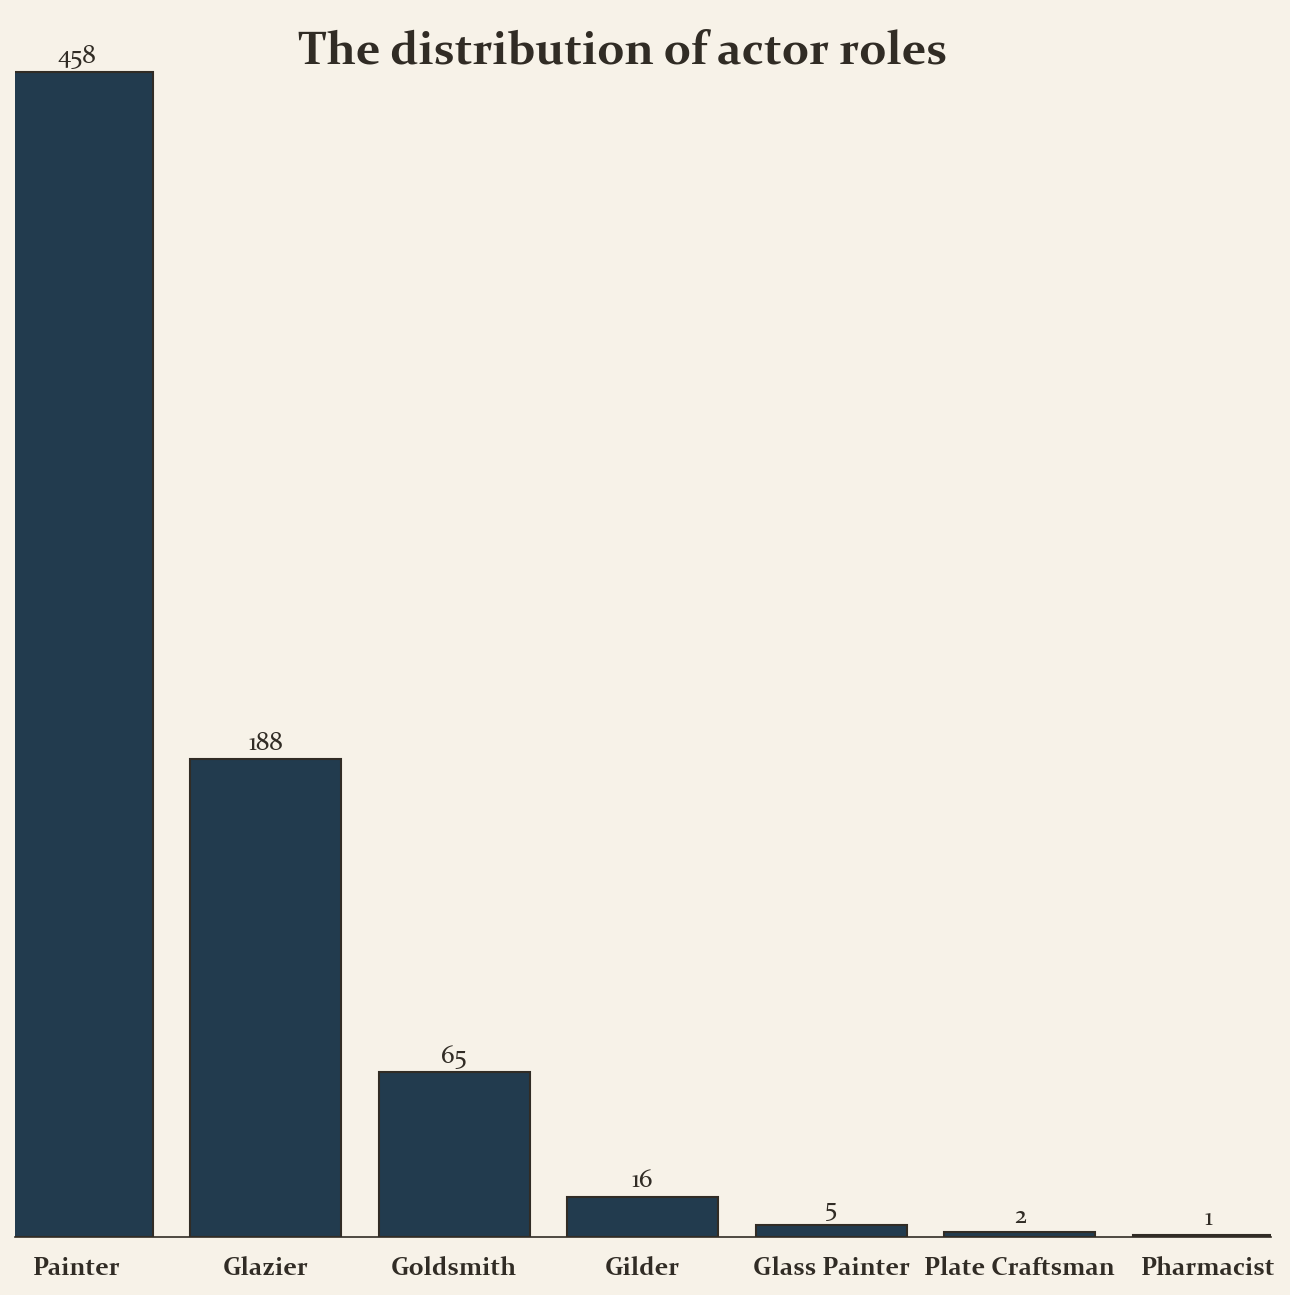

In [226]:
# --- data prep ---
subset = (dataset.loc[:, ["actor_id", "role"]]
               .groupby("actor_id")
               .first()
               .reset_index()
               .drop(["actor_id"], axis=1)
               .value_counts()
               .reset_index()
               .rename({0: "count"}, axis=1))

# --- fig setup ---
fig = plt.figure(figsize=(10.80, 10.80),
                 dpi=150)

ax = fig.add_subplot(1, 1, 1)

# --- plot ---
bar = ax.bar(x=[0, 1, 2, 3, 4, 5, 6],
             height=subset["count"],
             tick_label=subset["role"].str.title(),
             color="#223B4E",
             linewidth=1,
             edgecolor="#312C25",
             align="center")

# --- configure params --- 
# spines and axes
for spine in ["left", "right", "top"]:
    ax.spines[spine].set_visible(False)
ax.axes.set_xlim(-0.33, 6.33)

# axis ticks
ax.set_yticks([])

ax.tick_params(axis = "both",
    which = "both",
    bottom = False,
    top = False,
    left = False,
    right = False,
    pad = 5)

# titles and annotation
# fig title
plt.figtext(s="The distribution of actor roles",
          x=0.50,
          y=0.85,
          va="baseline",
          ha="center",
          fontsize=22,
          fontweight="bold")
          
# axis labels
ax.set_xticklabels(subset["role"].str.title(),
                   fontsize=12,
                   fontweight = "bold")

# tick labels
ax.set_yticklabels([])

# bar annotation
labels = ax.bar_label(bar, padding=2)


As it can be seen from the bar chart above, the role of "painter" dominates over all other roles by a wide margin. There are 458 painters recorded in the dataset, following by 188 glaziers and 65 goldsmiths. The other four roles make up an insignificant percentage when compared to the top three roles.

Now that we know what roles there are in the dataset and their prevalence levels, we can look at the actor status feature.

#### Actor status

All of the artists in the dataset have a status attached to them as well as a role. The status of an actor signifies his/her experience level, often tied with the time spent with the guild. There are six distinct status recorded in the guild books: apprentice, master, non-sworn in master, master's son, tutor and dean. These roles present to us some kind of a partial hiearchy: The status of "apprentice" (the most populous status group) is lower in rank than the status of master, the status of master is lower in rank than the status of tutor, and the status of master is lower in rank than the status of dean. The two remaining roles cannot exactly be placed within this hierarchy. The dataset does not provide any information about whether non-sworn in master's are held in the same regard as in sworn-in masters, and the artistic merit of a master's son is questionable.

Below is another bar chart that shows the distribution of the feature "actor status".

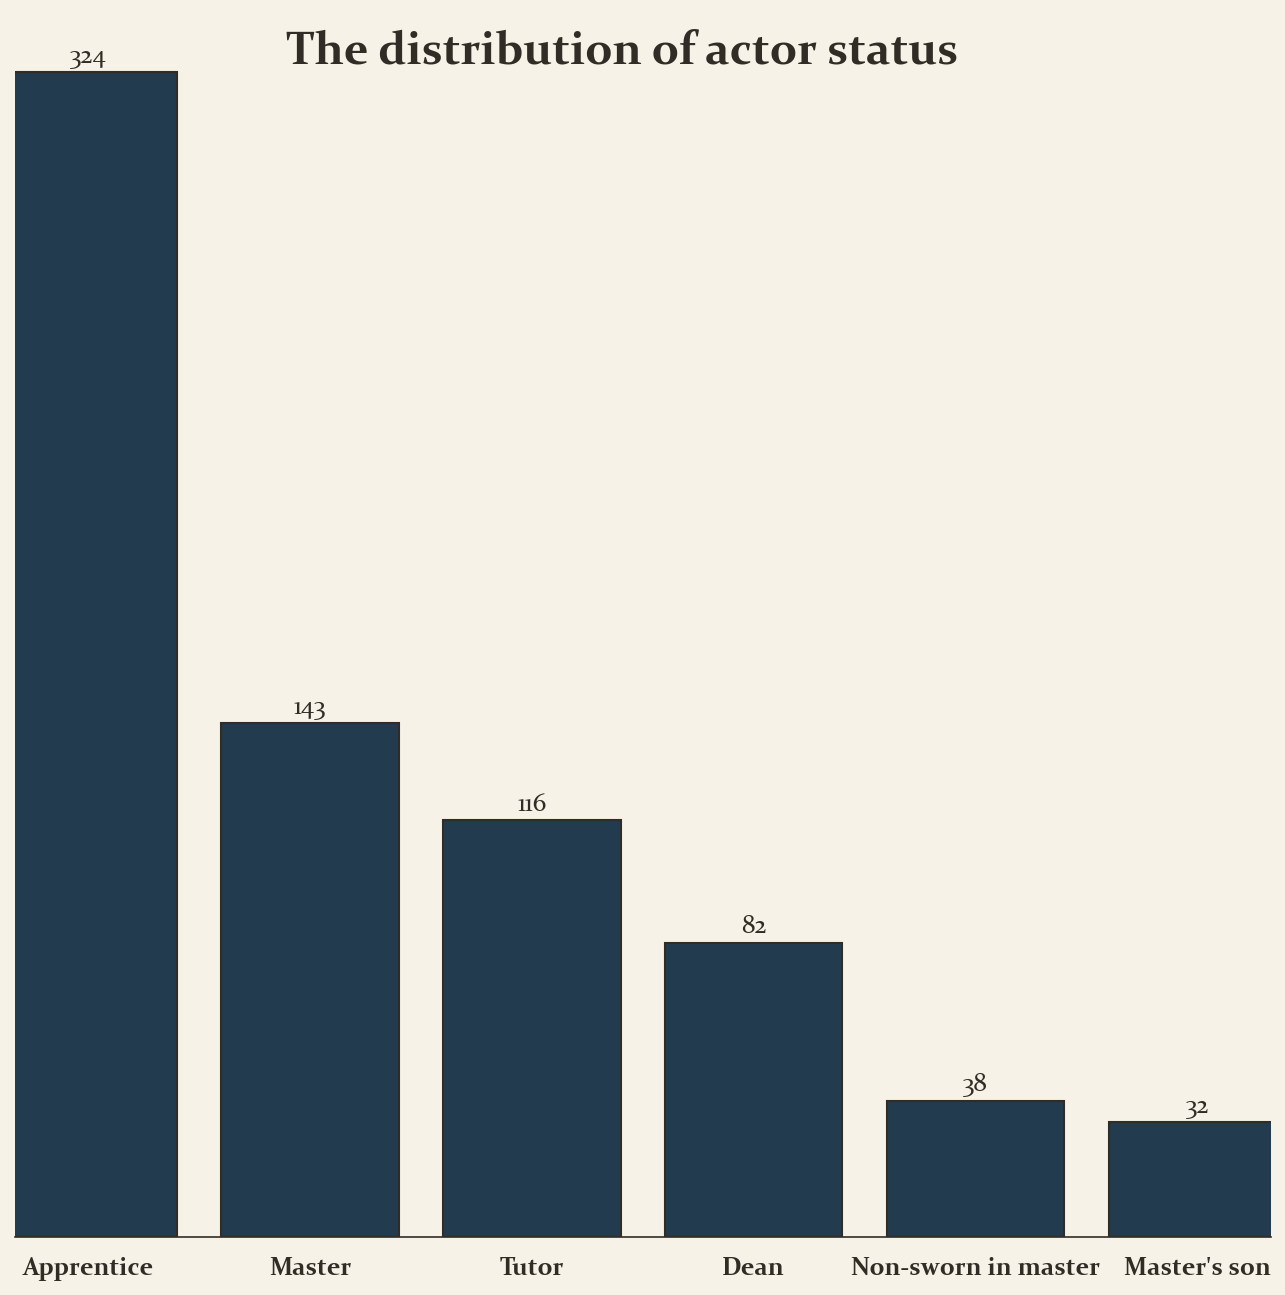

In [227]:
# --- data prep ---
subset = (dataset.loc[:, ["actor_id", "status"]]
               .groupby("actor_id")
               .first()
               .reset_index()
               .drop(["actor_id"], axis=1)
               .value_counts()
               .reset_index()
               .rename({0: "count"}, axis=1))

# --- fig setup ---
fig = plt.figure(figsize=(10.80, 10.80),
                 dpi=150)

ax = fig.add_subplot(1, 1, 1)

# --- plot ---
bar = ax.bar(x=[0, 1, 2, 3, 4, 5],
             height=subset["count"],
             tick_label=subset["status"].str.title(),
             color="#223B4E",
             linewidth=1,
             edgecolor="#312C25",
             align="center")

# --- configure params --- 
# spines and axes
for spine in ["left", "right", "top"]:
    ax.spines[spine].set_visible(False)
ax.axes.set_xlim(-0.33, 5.33)

# axis ticks
ax.set_yticks([])

ax.tick_params(axis = "both",
    which = "both",
    bottom = False,
    top = False,
    left = False,
    right = False,
    pad = 5)

# titles and annotation
# fig title
plt.figtext(s="The distribution of actor status",
          x=0.50,
          y=0.85,
          va="baseline",
          ha="center",
          fontsize=22,
          fontweight="bold")
          
# axis labels
ax.set_xticklabels(subset["status"].str.capitalize(),
                   fontsize=12,
                   fontweight = "bold")

# tick labels
ax.set_yticklabels([])

# bar annotation
labels = ax.bar_label(bar, padding=2)

The distribution of actor status over the dataset mirrors the hierarchical structure of the status: there are more apprentices than there are masters, there are more masters than there are tutors, and there are more tutors than there are deans. What's surprising is the fact that the status of "non-sworn in master" and "master's son" are prevalent in significant levels.

#### Interaction of actor role and actor status

These two crucial categorical features can also be investigated in unison. It might be interesting to know statistics like:
- The percentage of apprentices that were painters versus the percentage of apprentices that were goldsmiths
- The percentage of masters that were pharmacist versus the percentage of masters that were glaziers.

In [239]:
# --- data prep ---
subset = (dataset.loc[:, ["actor_id", "role", "status"]]
               .groupby("actor_id")
               .first()
               .reset_index()
               .drop(["actor_id"], axis=1)
               .groupby("status")
               .agg({"role": "sum"}))
subset

,role
status,
apprentice,painterpainterpainterpainterpaintergoldsmithpa...
dean,painterpainterpainterpainterglazierglazierglaz...
master,painterpaintergoldsmithpainterpainterpaintergl...
master's son,glazierpainterpainterglazierpainterpaintergold...
non-sworn in master,painterpainterpainterpainterpainterpainterpain...
tutor,painterpainterpainterpainterpainterpainterpain...
